In [1]:
# Cell 1: Setup and Imports
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.metrics import roc_auc_score, make_scorer
from category_encoders import TargetEncoder
import logging
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from imblearn.over_sampling import SMOTE
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin
import os
from datetime import datetime

# Get the current timestamp
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')

# Define the log file name with the timestamp
log_file_name = f'training_{timestamp}.log'

# Check if a similar log file exists and remove it if necessary
if os.path.exists('training.log'):
    os.remove('training.log')

# Configure logger
logger = logging.getLogger(__name__)
logger.setLevel(logging.INFO)

# Create handlers
console_handler = logging.StreamHandler()
file_handler = logging.FileHandler(log_file_name)

# Set log level for handlers
console_handler.setLevel(logging.INFO)
file_handler.setLevel(logging.INFO)

# Create formatters and add them to the handlers
console_format = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
file_format = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
console_handler.setFormatter(console_format)
file_handler.setFormatter(file_format)

# Add handlers to the logger
logger.addHandler(console_handler)
logger.addHandler(file_handler)

# Example logging usage
logger.info("Setup and Imports complete.")


c:\Users\paulo\anaconda3\envs\pytorch_env\Lib\site-packages\dask\dataframe\__init__.py:31: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)
2024-07-13 20:13:36,317 - __main__ - INFO - Setup and Imports complete.


In [2]:
# # Cell 2: Load and Prepare Data
# logger.info("Loading and preparing data...")

# def reduce_memory_usage(df):
#     """Iterate through all the columns of a dataframe and modify the data type to reduce memory usage."""
#     start_mem = df.memory_usage().sum() / 1024**2
#     for col in df.columns:
#         col_type = df[col].dtype
        
#         if col_type != object:
#             c_min = df[col].min()
#             c_max = df[col].max()
            
#             if str(col_type)[:3] == 'int':
#                 if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
#                     df[col] = df[col].astype(np.int8)
#                 elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
#                     df[col] = df[col].astype(np.int16)
#                 elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
#                     df[col] = df[col].astype(np.int32)
#                 elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
#                     df[col] = df[col].astype(np.int64)  
#             else:
#                 if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
#                     df[col] = df[col].astype(np.float16)
#                 elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
#                     df[col] = df[col].astype(np.float32)
#                 else:
#                     df[col] = df[col].astype(np.float64)
#         else:
#             df[col] = df[col].astype('category')

#     end_mem = df.memory_usage().sum() / 1024**2
#     print(f'Memory usage after optimization is: {end_mem:.2f} MB')
#     print(f'Decreased by {(100 * (start_mem - end_mem) / start_mem):.2f}%')
    
#     return df

# # Load datasets and reduce memory usage
# train_df = pd.read_csv(r"C:\Users\paulo\OneDrive\Documents\Binary-Classification-of-Insurance-Cross-Selling\preprocessed_train.csv")
# test_df = pd.read_csv(r"C:\Users\paulo\OneDrive\Documents\Binary-Classification-of-Insurance-Cross-Selling\preprocessed_test.csv")

# train_df = reduce_memory_usage(train_df)
# test_df = reduce_memory_usage(test_df)

# # Drop ID column from training and test data
# train_df.drop(columns=['id'], inplace=True)
# test_df.drop(columns=['id'], inplace=True)

# logger.info(f"Train dataset shape: {train_df.shape}")
# logger.info(f"Test dataset shape: {test_df.shape}")

# # Split the data into training and validation sets before preprocessing
# X = train_df.drop(columns=['Response'])
# y = train_df['Response']
# X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# logger.info(f"Training set shape: {X_train.shape}")
# logger.info(f"Validation set shape: {X_val.shape}")


In [3]:
# # Cell 3: Define Custom Transformers
# logger.info("Defining custom transformers...")

# class InteractionFeatures(BaseEstimator, TransformerMixin):
#     def __init__(self):
#         pass
    
#     def fit(self, X, y=None):
#         return self
    
#     def transform(self, X):
#         X = X.copy()
#         X['Age_Annual_Premium'] = X['Age'] * X['Annual_Premium']
#         X['Age_Vintage'] = X['Age'] * X['Vintage']
#         X['Annual_Premium_Vintage'] = X['Annual_Premium'] * X['Vintage']
#         X['Age_Region_Code'] = X['Age'] * X['Region_Code']
#         X['Vintage_Region_Code'] = X['Vintage'] * X['Region_Code']
#         X['Annual_Premium_Region_Code'] = X['Annual_Premium'] * X['Region_Code']
#         return X

# class TargetEncoding(BaseEstimator, TransformerMixin):
#     def __init__(self):
#         self.encoder = TargetEncoder(cols=['Gender', 'Vehicle_Age', 'Vehicle_Damage'])
    
#     def fit(self, X, y=None):
#         self.encoder.fit(X, y)
#         return self
    
#     def transform(self, X):
#         return self.encoder.transform(X)

# class PolynomialFeatureGeneration(BaseEstimator, TransformerMixin):
#     def __init__(self):
#         self.poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
    
#     def fit(self, X, y=None):
#         self.poly.fit(X[['Age', 'Annual_Premium', 'Vintage']])
#         return self
    
#     def transform(self, X):
#         poly_features = self.poly.transform(X[['Age', 'Annual_Premium', 'Vintage']])
#         poly_feature_names = self.poly.get_feature_names_out(['Age', 'Annual_Premium', 'Vintage'])
#         poly_df = pd.DataFrame(poly_features, columns=[f'poly_{name.replace(" ", "_")}' for name in poly_feature_names], index=X.index)
#         X = pd.concat([X, poly_df], axis=1)
#         return X

# logger.info("Custom transformers defined.")


In [4]:
# # Cell 4: Define Preprocessing Pipeline
# logger.info("Defining preprocessing pipeline...")

# pipeline = Pipeline([
#     ('interactions', InteractionFeatures()),
#     ('target_encoding', TargetEncoding()),
#     ('poly_features', PolynomialFeatureGeneration()),
#     ('scaling', StandardScaler())
# ])

# # Apply the preprocessing pipeline
# X_train_preprocessed = pipeline.fit_transform(X_train, y_train)
# X_val_preprocessed = pipeline.transform(X_val)

# logger.info(f"Training set after preprocessing: {X_train_preprocessed.shape}")
# logger.info(f"Validation set after preprocessing: {X_val_preprocessed.shape}")


In [5]:
# # Cell 5: Handle Imbalanced Data and Verify Memory Reduction
# logger.info("Handling imbalanced data using SMOTE and verifying memory reduction...")

# # Handle imbalanced data using SMOTE on the training data
# smote = SMOTE()
# X_train_resampled, y_train_resampled = smote.fit_resample(X_train_preprocessed, y_train)

# logger.info(f"Training data resampled using SMOTE. New shape: {X_train_resampled.shape}")

# # Verify and reduce memory usage after SMOTE
# X_train_resampled = reduce_memory_usage(pd.DataFrame(X_train_resampled))
# X_val_preprocessed = reduce_memory_usage(pd.DataFrame(X_val_preprocessed))

# logger.info(f"Training data shape after memory reduction: {X_train_resampled.shape}")
# logger.info(f"Validation data shape after memory reduction: {X_val_preprocessed.shape}")

# # Save Transformed Data
# def save_csv(dataframe, filename):
#     if os.path.exists(filename):
#         os.remove(filename)
#     dataframe.to_csv(filename, index=False)

# save_csv(X_train_resampled, 'X_train_transformed_reduced.csv')
# save_csv(X_val_preprocessed, 'X_val_transformed_reduced.csv')
# save_csv(pd.DataFrame(y_train_resampled), 'y_train_transformed_reduced.csv')
# save_csv(pd.DataFrame(y_val), 'y_val_transformed_reduced.csv')

# logger.info("Transformed datasets saved to CSV files with reduced memory usage")

# If needed, load the transformed datasets from CSV
X_train_resampled = pd.read_csv('X_train_transformed_reduced.csv')
X_val_preprocessed = pd.read_csv('X_val_transformed_reduced.csv')
y_train_resampled = pd.read_csv('y_train_transformed_reduced.csv')
y_val = pd.read_csv('y_val_transformed_reduced.csv')


In [7]:
# Cell 6: Run Bayesian Search for Hyperparameter Tuning
from skopt import BayesSearchCV

logger.info("Running Bayesian search for hyperparameter tuning...")

def run_bayesian_search(X_train, y_train):
    # Define the parameter grid
    param_dist = {
        'learning_rate': (0.03, 0.1),
        'num_leaves': (60, 120),
        'max_depth': (10, 15),
        'min_data_in_leaf': (10, 50),
        'bagging_fraction': (0.6, 0.8),
        'feature_fraction': (0.6, 0.8),
        'lambda_l1': (0.0, 1.0),
        'lambda_l2': (0.0, 1.0),
        'bagging_freq': (1, 7)
    }

    # Initialize the LightGBM classifier
    lgb_model = lgb.LGBMClassifier(objective='binary', metric='auc')

    # Define the scoring function
    scorer = make_scorer(roc_auc_score, greater_is_better=True, needs_proba=True)

    # Initialize BayesSearchCV
    bayes_search = BayesSearchCV(
        estimator=lgb_model,
        search_spaces=param_dist,
        n_iter=5,  # Number of iterations for the search
        scoring=scorer,
        cv=3,  # 3-fold cross-validation
        random_state=42,
        verbose=2,
        n_jobs=-1
    )

    # Fit BayesSearchCV
    bayes_search.fit(X_train, y_train)

    return bayes_search.best_estimator_, bayes_search.best_params_, bayes_search.best_score_

# Run Bayesian Search
best_model, best_params, best_score = run_bayesian_search(X_train_resampled, y_train_resampled)

logger.info(f"Best AUC: {best_score}")
logger.info(f"Best parameters: {best_params}")

# Save the best trial parameters
pd.DataFrame([best_params]).to_csv('best_params_bayesiansearch.csv', index=False)

# Load the best parameters from the saved file (if needed)
best_params_loaded = pd.read_csv('best_params_bayesiansearch.csv').to_dict(orient='records')[0]

# Optionally, you can refit the model on the entire training set using the best parameters
best_model_retrained = lgb.LGBMClassifier(**best_params_loaded)
best_model_retrained.fit(X_train_resampled, y_train_resampled)

logger.info("Bayesian search complete.")


2024-07-13 20:25:50,079 - __main__ - INFO - Running Bayesian search for hyperparameter tuning...


c:\Users\paulo\anaconda3\envs\pytorch_env\Lib\site-packages\sklearn\metrics\_scorer.py:548: FutureWarning: The `needs_threshold` and `needs_proba` parameter are deprecated in version 1.4 and will be removed in 1.6. You can either let `response_method` be `None` or set it to `predict` to preserve the same behaviour.
  warnings.warn(


Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits


c:\Users\paulo\anaconda3\envs\pytorch_env\Lib\site-packages\sklearn\preprocessing\_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\paulo\anaconda3\envs\pytorch_env\Lib\site-packages\sklearn\preprocessing\_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Warning] min_data_in_leaf is set=36, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=36
[LightGBM] [Warning] feature_fraction is set=0.7053240474255384, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7053240474255384
[LightGBM] [Warning] lambda_l1 is set=0.715713262107033, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.715713262107033
[LightGBM] [Warning] lambda_l2 is set=0.9038520725066866, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.9038520725066866
[LightGBM] [Warning] bagging_fraction is set=0.7599106883214346, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7599106883214346
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] min_data_in_leaf is set=36, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=36
[LightGBM] [Warning] feature_fraction is set=0.7053240474255384, colsample_bytree=

2024-07-13 20:35:39,864 - __main__ - INFO - Best AUC: 0.9486205614107845
2024-07-13 20:35:39,865 - __main__ - INFO - Best parameters: OrderedDict({'bagging_fraction': 0.7599106883214346, 'bagging_freq': 4, 'feature_fraction': 0.7053240474255384, 'lambda_l1': 0.715713262107033, 'lambda_l2': 0.9038520725066866, 'learning_rate': 0.0801921805811886, 'max_depth': 12, 'min_data_in_leaf': 36, 'num_leaves': 81})
c:\Users\paulo\anaconda3\envs\pytorch_env\Lib\site-packages\sklearn\preprocessing\_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\paulo\anaconda3\envs\pytorch_env\Lib\site-packages\sklearn\preprocessing\_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=

[LightGBM] [Warning] min_data_in_leaf is set=36, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=36
[LightGBM] [Warning] feature_fraction is set=0.7053240474255384, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7053240474255384
[LightGBM] [Warning] lambda_l1 is set=0.715713262107033, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.715713262107033
[LightGBM] [Warning] lambda_l2 is set=0.9038520725066866, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.9038520725066866
[LightGBM] [Warning] bagging_fraction is set=0.7599106883214346, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7599106883214346
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] min_data_in_leaf is set=36, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=36
[LightGBM] [Warning] feature_fraction is set=0.7053240474255384, colsample_bytree=

2024-07-13 20:36:38,853 - __main__ - INFO - Bayesian search complete.


In [8]:
# Cell 7: Model Evaluation
logger.info("Evaluating model...")

def evaluate_model(model, X_train, y_train, X_val, y_val):
    # Evaluate the best model on the training set
    train_preds = model.predict_proba(X_train)[:, 1]
    train_auc = roc_auc_score(y_train, train_preds)

    # Evaluate the best model on the validation set
    val_preds = model.predict_proba(X_val)[:, 1]
    val_auc = roc_auc_score(y_val, val_preds)

    logger.info(f"Training AUC with best parameters: {train_auc}")
    logger.info(f"Validation AUC with best parameters: {val_auc}")

    # Check for overfitting
    overfit_threshold = 0.05  # Adjust the threshold as needed
    overfit_metric = abs(train_auc - val_auc)
    if overfit_metric > overfit_threshold:
        logger.warning(f"Overfitting detected: Train AUC - {train_auc}, Val AUC - {val_auc}, Difference - {overfit_metric}")
    else:
        logger.info(f"No overfitting detected: Train AUC - {train_auc}, Val AUC - {val_auc}, Difference - {overfit_metric}")

    return train_auc, val_auc

# Evaluate the best model
train_auc, val_auc = evaluate_model(best_model_retrained, X_train_resampled, y_train_resampled, X_val_preprocessed, y_val)

logger.info("Model evaluation complete.")


2024-07-13 20:36:38,886 - __main__ - INFO - Evaluating model...


[LightGBM] [Warning] min_data_in_leaf is set=36, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=36
[LightGBM] [Warning] feature_fraction is set=0.7053240474255384, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7053240474255384
[LightGBM] [Warning] lambda_l1 is set=0.715713262107033, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.715713262107033
[LightGBM] [Warning] lambda_l2 is set=0.9038520725066866, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.9038520725066866
[LightGBM] [Warning] bagging_fraction is set=0.7599106883214346, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7599106883214346
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] min_data_in_leaf is set=36, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=36
[LightGBM] [Warning] feature_fraction is set=0.7053240474255384, colsample_bytree=

2024-07-13 20:37:08,139 - __main__ - INFO - Training AUC with best parameters: 0.9493483645407668
2024-07-13 20:37:08,139 - __main__ - INFO - Validation AUC with best parameters: 0.8627342805093273
2024-07-13 20:37:08,139 - __main__ - WARNING - Overfitting detected: Train AUC - 0.9493483645407668, Val AUC - 0.8627342805093273, Difference - 0.08661408403143944
2024-07-13 20:37:08,150 - __main__ - INFO - Model evaluation complete.


In [9]:
# Cell 8: Train Final Model with Callbacks
logger.info("Training final model with callbacks...")

def train_final_model(params, X_train, y_train, X_val, y_val):
    # Create LightGBM datasets
    train_data = lgb.Dataset(X_train, label=y_train, free_raw_data=False)
    val_data = lgb.Dataset(X_val, label=y_val, reference=train_data, free_raw_data=False)

    # Define the early stopping callback
    early_stopping_callback = lgb.early_stopping(stopping_rounds=20, first_metric_only=True, verbose=True)

    # Train the LightGBM model with the best parameters
    model = lgb.train(
        params,
        train_data,
        num_boost_round=200,
        valid_sets=[train_data, val_data],
        callbacks=[early_stopping_callback],
    )

    return model

# Train the final model
final_model = train_final_model(best_params_loaded, X_train_resampled, y_train_resampled, X_val_preprocessed, y_val)


2024-07-13 20:37:08,167 - __main__ - INFO - Training final model with callbacks...


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.440411 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4356
[LightGBM] [Info] Number of data points in the train set: 16086232, number of used features: 21
[LightGBM] [Info] Start training from score 0.500000
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[200]	training's l2: 0.0920605	valid_1's l2: 0.11835
Evaluated only: l2


2024-07-13 20:38:36,862 - __main__ - INFO - Saving model and metrics...
2024-07-13 20:39:11,702 - __main__ - INFO - Final Train AUC: 0.9521649122773773
2024-07-13 20:39:11,703 - __main__ - INFO - Final Validation AUC: 0.8610571035742743
2024-07-13 20:39:11,766 - __main__ - INFO - Feature importance saved as feature_importance.csv
2024-07-13 20:39:12,916 - __main__ - INFO - Feature importance plot saved as feature_importance.png


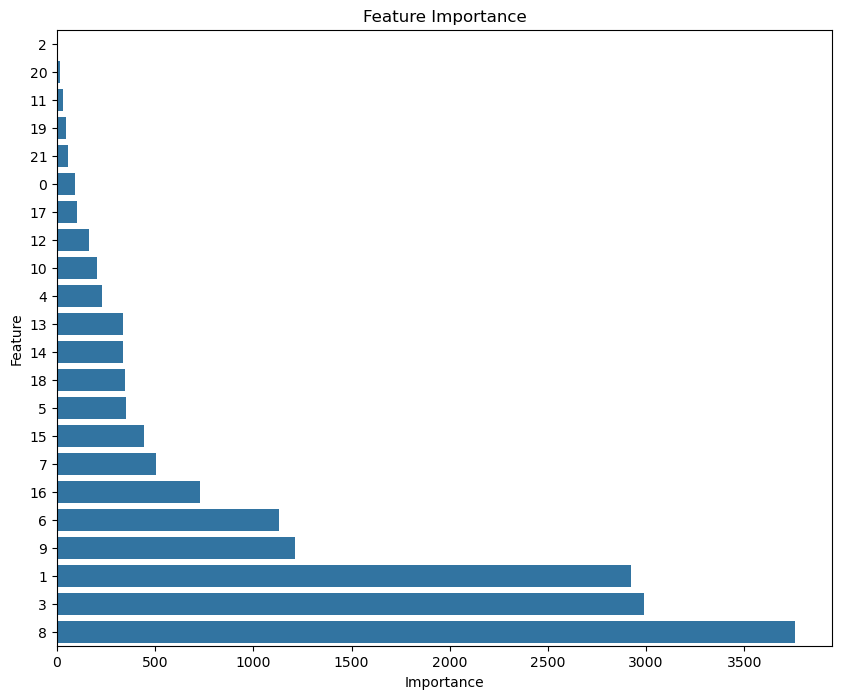

2024-07-13 20:39:13,087 - __main__ - INFO - Model saved as lightgbm_model_best.pkl
2024-07-13 20:39:13,099 - __main__ - INFO - Model metrics saved as model_metrics.csv
2024-07-13 20:39:13,099 - __main__ - INFO - Training and evaluation process completed successfully.


In [10]:
# Cell 9: Save Model and Metrics
logger.info("Saving model and metrics...")

def save_csv(dataframe, filename):
    if os.path.exists(filename):
        os.remove(filename)
    dataframe.to_csv(filename, index=False)

def save_model_and_metrics(model, train_auc, val_auc):
    # Predict on train and validation set
    y_train_pred = model.predict(X_train_resampled, num_iteration=model.best_iteration)
    y_val_pred = model.predict(X_val_preprocessed, num_iteration=model.best_iteration)

    # Evaluation metrics
    train_auc = roc_auc_score(y_train_resampled, y_train_pred)
    val_auc = roc_auc_score(y_val, y_val_pred)

    logger.info(f"Final Train AUC: {train_auc}")
    logger.info(f"Final Validation AUC: {val_auc}")

    # Feature Importance
    importance = model.feature_importance(importance_type='split')
    feature_names = model.feature_name()

    # Create a DataFrame for feature importance
    feature_importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importance
    }).sort_values(by='Importance', ascending=False)

    # Save feature importance to CSV
    save_csv(feature_importance_df, "feature_importance.csv")
    logger.info("Feature importance saved as feature_importance.csv")

    # Plot feature importance
    plt.figure(figsize=(10, 8))
    sns.barplot(data=feature_importance_df, x='Importance', y='Feature')
    plt.xlabel("Importance")
    plt.ylabel("Feature")
    plt.title("Feature Importance")
    plt.gca().invert_yaxis()
    plt.savefig("feature_importance.png")
    logger.info("Feature importance plot saved as feature_importance.png")

    plt.show()

    # Save the model and metrics
    if os.path.exists("lightgbm_model_best.pkl"):
        os.remove("lightgbm_model_best.pkl")
    joblib.dump(model, "lightgbm_model_best.pkl")
    logger.info("Model saved as lightgbm_model_best.pkl")

    # Save the metrics to a CSV file
    metrics = {
        "train_auc": train_auc,
        "val_auc": val_auc
    }

    metrics_df = pd.DataFrame(metrics, index=[0])
    save_csv(metrics_df, "model_metrics.csv")
    logger.info("Model metrics saved as model_metrics.csv")

    # Final log message
    logger.info("Training and evaluation process completed successfully.")

# Save the model and metrics
save_model_and_metrics(final_model, train_auc, val_auc)
